# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [3]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [4]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for the bonus section.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [33]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [154]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = np.logspace(-8, -9, 10) 
regularization_strengths = 2.5*np.logspace(5, 6, 10)

results = {}
best_val = -1
best_svm = None

pass
################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
for lr in learning_rates:
    for rs in regularization_strengths:
        # Train SVM
        svm = LinearSVM()
        loss_hist = svm.train(X_train_feats, y_train, learning_rate=lr, 
                        reg=rs, num_iters=1500, verbose=False)
        # Test SVM
        y_train_pred = svm.predict(X_train_feats)
        train_acc = np.mean(y_train == y_train_pred)
        y_val_pred = svm.predict(X_val_feats)
        val_acc = np.mean(y_val == y_val_pred)
        results[(lr, rs)] = (train_acc, val_acc)
        print("train acc: {}, val acc: {}".format(train_acc, val_acc))
        # Check for new best
        if val_acc > best_val:
            best_val = val_acc
            best_svm = svm
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

train acc: 0.347285714286, val acc: 0.371
train acc: 0.411408163265, val acc: 0.416
train acc: 0.415857142857, val acc: 0.423
train acc: 0.412857142857, val acc: 0.417
train acc: 0.41406122449, val acc: 0.417
train acc: 0.413734693878, val acc: 0.413
train acc: 0.412285714286, val acc: 0.412
train acc: 0.408693877551, val acc: 0.405
train acc: 0.40287755102, val acc: 0.398
train acc: 0.415775510204, val acc: 0.405
train acc: 0.167959183673, val acc: 0.169
train acc: 0.328857142857, val acc: 0.31
train acc: 0.411448979592, val acc: 0.426
train acc: 0.415551020408, val acc: 0.42
train acc: 0.415530612245, val acc: 0.437
train acc: 0.412959183673, val acc: 0.407
train acc: 0.418081632653, val acc: 0.416
train acc: 0.41212244898, val acc: 0.412
train acc: 0.412816326531, val acc: 0.42
train acc: 0.409428571429, val acc: 0.407
train acc: 0.125163265306, val acc: 0.114
train acc: 0.179163265306, val acc: 0.18
train acc: 0.300346938776, val acc: 0.293
train acc: 0.409918367347, val acc: 0.413

In [155]:
lr_dict = {}
for lr in learning_rates:
    for rs in regularization_strengths:
        if lr not in lr_dict:
            lr_dict[lr] = []
        lr_dict[lr].append(results[(lr,rs)])
        
rs_dict = {}
for rs in regularization_strengths:
    for lr in learning_rates:
        if rs not in rs_dict:
            rs_dict[rs] = []
        rs_dict[rs].append(results[(lr,rs)])

print("Learning rates:")
for lr in sorted(lr_dict):
    print(lr, np.mean(lr_dict[lr]))
    
print("Reg strengths:")
for rs in sorted(rs_dict):
    print(rs, np.mean(rs_dict[rs]))

Learning rates:
1e-09 0.107339795918
1.29154966501e-09 0.134956122449
1.6681005372e-09 0.165194897959
2.15443469003e-09 0.200715306122
2.78255940221e-09 0.236960204082
3.5938136638e-09 0.268960204082
4.64158883361e-09 0.306162244898
5.99484250319e-09 0.34797755102
7.74263682681e-09 0.381437755102
1e-08 0.406591836735
Reg strengths:
250000.0 0.133371428571
322887.416254 0.157540816327
417025.1343 0.188030612245
538608.672508 0.214026530612
695639.850552 0.23885
898453.415951 0.26973877551
1160397.2084 0.299545918367
1498710.6258 0.321884693878
1935659.2067 0.356715306122
2500000.0 0.376591836735


In [158]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.422


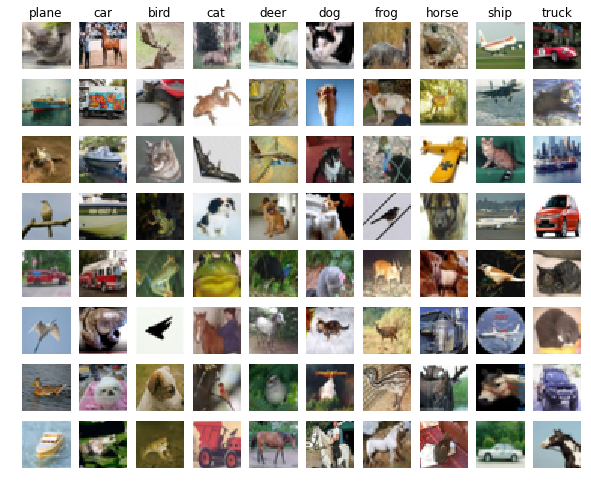

In [160]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

Many of the misclassifications are logical. Some of the images misclassified as planes were actually birds, which is interesting, since planes are modeled after birds and do look similar. Most of the false cars are trucks or ships, which should share similar features since they are all vehicles. Planes and ships are mixed up, which makes sense, since many both have blue backgrounds. For those misclassifications which are harder to parse, e.g. dog misclassifed as car, there may be less intuitive feature similarities, like eyes corresponding to headlights, or legs corresponding to wheels. There is also a pattern of misclassified images sharing edge similarities with the true class, as explained by the HOG component of the features. For example, a horse may not look like a truck, but if it is in the right orientation, it may share a lot of edge information with a truck.

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

iteration 0 / 1000: loss 2.302585
iteration 100 / 1000: loss 1.512073
iteration 200 / 1000: loss 1.247028
iteration 300 / 1000: loss 1.325965
iteration 400 / 1000: loss 1.356949
iteration 500 / 1000: loss 1.142765
iteration 600 / 1000: loss 1.080716
iteration 700 / 1000: loss 1.045584
iteration 800 / 1000: loss 0.845833
iteration 900 / 1000: loss 0.793586
Validation accuracy:  0.577


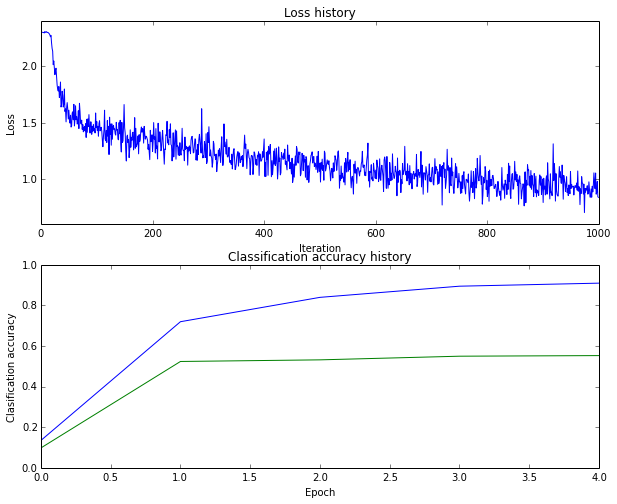

In [189]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 1000
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
net = TwoLayerNet(input_dim, hidden_dim, num_classes)

# Train the network
stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
            num_iters=1000, batch_size=200,
            learning_rate=1, learning_rate_decay=0.95,
            reg=0, verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val_feats) == y_val).mean()
print('Validation accuracy: ', val_acc)

# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.show()
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

In [190]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.

test_acc = (net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.557


# Bonus: Design your own features!

You have seen that simple image features can improve classification performance. So far we have tried HOG and color histograms, but other types of features may be able to achieve even better classification performance.

For bonus points, design and implement a new type of feature and use it for image classification on CIFAR-10. Explain how your feature works and why you expect it to be useful for image classification. Implement it in this notebook, cross-validate any hyperparameters, and compare its performance to the HOG + Color histogram baseline.

480


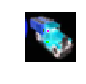

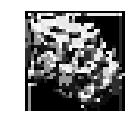

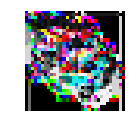

In [44]:
import itertools
import numpy as np

# My own implementation of Local Binary Patterns
# Just uses 8 neighbors
p = list(itertools.product([-1,0,1], repeat=2))
p.remove((0,0))
ii,ij = np.array(zip(*p))

def lbp_kernel(img, i, j):
    # Get vals around i,j, account for padding
    vals = img[ii+i+1, ij+j+1]
    # Check if <,>, make bit vector
    lbp = np.clip(vals-img[i+1,j+1], 0, 1).astype(int)
    # Convert to scalar
    val = np.packbits(lbp)
    return np.asscalar(val)

def get_lbp_gray(img, cell_size=(8,8), num_bins=10):
    # Get shape
    N,M = img.shape
    # Zero pad img
    padded = np.pad(img, ((1,1),(1,1)), 'constant')
    # Get lbp values for each cell
    cells = {}
    for i in range(0, N, cell_size[0]):
        for j in range(0, M, cell_size[1]):
            cells[(i,j)] = []
            for k in range(i, i+cell_size[0]):
                for l in range(j, j+cell_size[1]):
                    v = lbp_kernel(padded, k, l)
                    cells[(i,j)].append(v)
    # make histograms from cells
    feat = []
    for v in cells.values():
        h = np.histogram(v, num_bins, (0.0, 256.0), density=True)[0]
        feat.extend(h)
    return feat

def lbp_img_gray(img):
    # Get shape
    N,M = img.shape
    # Zero pad img
    padded = np.pad(img, ((1,1),(1,1)), 'constant')
    # Get lbp values for each cell
    new = np.zeros((N,M))
    for i in range(0, N):
        for j in range(0, M):
            v = lbp_kernel(padded, i, j)
            new[i,j] = v
    return new
    
def get_lbp_color(img, cell_size=(8,8), num_bins=10):
    feat = []
    for i in range(3):
        f = get_lbp_gray(img[:,:,i], 
            cell_size=cell_size, num_bins=num_bins)
        feat.extend(f)
    return feat

def lbp_img_color(img, cell_size=(8,8), num_bins=10):
    feat = np.zeros_like(img)
    for i in range(3):
        f = lbp_img_gray(img[:,:,i])
        feat[:,:,i]= f
    return feat

def get_set_lbp(img_set):
    feat_list = []
    for i,img in enumerate(img_set):
        lbp = get_lbp_color(img)
        feat_list.append(lbp)
        if i%1000 == 0:
            print("{}/{}".format(i, len(img_set)))
    return np.array(feat_list)
        

# Simple test
img = X_val[1]
gray = img[:,:,2]
lbp_gray = lbp_img_gray(gray)
lbp_color = lbp_img_color(img)
print(len(lbp))

#X_val_lbp = get_set_lbp(X_val)
#print(X_val_lbp.shape)

dpi = 80.0
xpix, ypix = 32, 32

plt.figure(figsize=(xpix/dpi*2, ypix/dpi*2), dpi=dpi)
plt.axis('off')
plt.imshow(img, interpolation='nearest')
plt.figure(figsize=(xpix/dpi*4, ypix/dpi*4), dpi=dpi)
plt.axis('off')
plt.imshow(lbp_gray, interpolation='nearest')
plt.figure(figsize=(xpix/dpi*4, ypix/dpi*4), dpi=dpi)
plt.axis('off')
plt.imshow(lbp_color, interpolation='nearest')

In [218]:
X_train_lbp = get_set_lbp(X_train)
X_val_lbp = get_set_lbp(X_val)
X_test_lbp = get_set_lbp(X_test)

0/49000
1000/49000
2000/49000
3000/49000
4000/49000
5000/49000
6000/49000
7000/49000
8000/49000
9000/49000
10000/49000
11000/49000
12000/49000
13000/49000
14000/49000
15000/49000
16000/49000
17000/49000
18000/49000
19000/49000
20000/49000
21000/49000
22000/49000
23000/49000
24000/49000
25000/49000
26000/49000
27000/49000
28000/49000
29000/49000
30000/49000
31000/49000
32000/49000
33000/49000
34000/49000
35000/49000
36000/49000
37000/49000
38000/49000
39000/49000
40000/49000
41000/49000
42000/49000
43000/49000
44000/49000
45000/49000
46000/49000
47000/49000
48000/49000
0/1000
0/1000


In [219]:
# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_lbp, axis=0, keepdims=True)
X_train_lbp -= mean_feat
X_val_lbp -= mean_feat
X_test_lbp -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_lbp, axis=0, keepdims=True)
X_train_lbp /= std_feat
X_val_lbp /= std_feat
X_test_lbp /= std_feat

# Preprocessing: Add a bias dimension
X_train_lbp = np.hstack([X_train_lbp, np.ones((X_train_lbp.shape[0], 1))])
X_val_lbp = np.hstack([X_val_lbp, np.ones((X_val_lbp.shape[0], 1))])
X_test_lbp = np.hstack([X_test_lbp, np.ones((X_test_lbp.shape[0], 1))])

iteration 0 / 1500: loss 2.302585
iteration 100 / 1500: loss 1.402105
iteration 200 / 1500: loss 1.385952
iteration 300 / 1500: loss 1.179126
iteration 400 / 1500: loss 1.115392
iteration 500 / 1500: loss 0.920286
iteration 600 / 1500: loss 0.799064
iteration 700 / 1500: loss 0.707433
iteration 800 / 1500: loss 0.582030
iteration 900 / 1500: loss 0.565882
iteration 1000 / 1500: loss 0.447772
iteration 1100 / 1500: loss 0.369542
iteration 1200 / 1500: loss 0.321686
iteration 1300 / 1500: loss 0.264425
iteration 1400 / 1500: loss 0.205986
Validation accuracy:  0.57
Test accuracy:  0.605


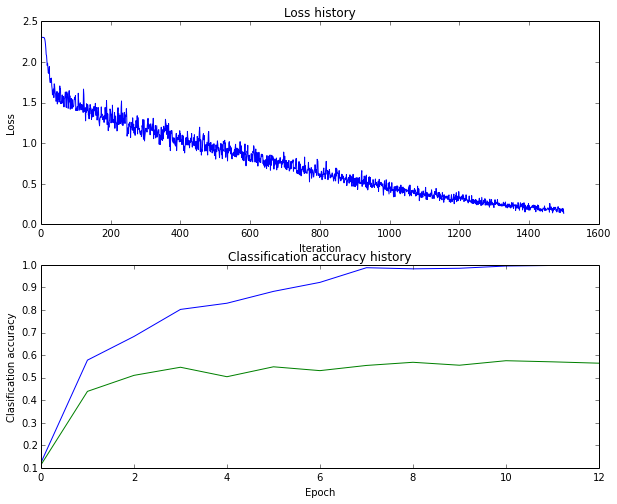

In [265]:
# Here we test the two-layer net on the LBP features
# the best accuracy achieved on the test set was 60%
input_dim = X_train_lbp.shape[1]
hidden_dim = 1000
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)

# Train the network
stats = net.train(X_train_lbp, y_train, X_val_lbp, y_val,
            num_iters=1500, batch_size=400,
            learning_rate=1, learning_rate_decay=0.90,
            reg=0, verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val_lbp) == y_val).mean()
print('Validation accuracy: ', val_acc)
test_acc = (net.predict(X_test_lbp) == y_test).mean()
print('Test accuracy: ', test_acc)

# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.show()

# Bonus: Do something extra!
Use the material and code we have presented in this assignment to do something interesting. Was there another question we should have asked? Did any cool ideas pop into your head as you were working on the assignment? This is your chance to show off!